In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt 
import seaborn as sns


In [2]:
df = pd.read_csv('dataset.csv')
original_feature_name = ['Catalyst', 'pH', 'Catalyst dosage (g/L)', '[C0] MO (mg/L)', '[C0] 2,4-DCP (mg/L)', 'H2O2 (mM)', 'Time (min)'] #, 'DE%'
catalyst_dict = {
    3: ('MTW'),
    2: ('MFS'),
    1: ('Cu-MTW'),
    0: ('Cu-MFS'),
}
renamed_features = ['Catalyst', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 't']

In [3]:
features = df.drop(columns=['t'])
target = df['t']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)

In [5]:
# Creating LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Defining parameters for the LightGBM model
params = {
    # 'boosting_type': 'gbdt', 
    'n_estimators':8000, 
    # 'learning_rate' :  0.12, 
    # 'num_leaves' : 250, 
    # 'subsample_for_bin': 165700, 
    # 'min_child_samples': 114, 
    # 'reg_alpha': 2.075e-06, 
    # 'reg_lambda': 3.839e-07, 
    # 'colsample_bytree': 0.9634,
    # 'subsample': 0.9592, 
    # 'max_depth': 10,
    # 'random_state':0,
    'verbosity':-1}

# Training the model
model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, test_data])


/home/erfan/anaconda3/envs/deep/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [6]:
model_predictions = model.predict(X_test, num_iteration=model.best_iteration)
r2 = r2_score(y_test, model_predictions)
print('R2 score = %f' %r2.round(3))

R2 score = 0.954000


In [7]:
RF_feature_importance_df = pd.DataFrame()
feature_names = original_feature_name
RF_feature_importance_df['Feature'] = feature_names
feature_importance = model.feature_importances_
RF_feature_importance_df['Importance'] = feature_importance
RF_feature_importance_df.sort_values(by='Importance', ascending=False)

AttributeError: 'Booster' object has no attribute 'feature_importances_'

In [8]:
import numpy as np

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6), tight_layout=True)
sns.set_style('whitegrid')
plt.tick_params(axis='x', labelsize=15)
plt.title('Feature Importance for Light Gradient Boosting model', y=1.06, x= .4, fontsize= 16, fontdict={'fontweight': 'bold', 'color': '#305f7f'})
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(original_feature_name)[sorted_idx], fontsize=11 ,fontdict={'fontweight': 'bold', 'color': '#305f7f'})
# plt.title('Feature Importance for GradientBoost model', fontdict={'weight':␣'bold'})
plt.grid(None)
plt.savefig('images/Feature_Importance_for_lgb_model.png', dpi=2000)
plt.show()

AttributeError: 'Booster' object has no attribute 'feature_importances_'

In [9]:
feature_names = original_feature_name + ['DE%']
df.columns = feature_names

r2_train = r2_score(y_train, model.predict(X_train))
mse_train = mean_squared_error(y_train, model.predict(X_train))
rmse_train = np.sqrt(mse_train)
sse_train = np.sum((y_train - model.predict(X_train)) ** 2)
sae_train = np.sum(np.abs(y_train - model.predict(X_train)))
mae_train = mean_absolute_error(y_train, model.predict(X_train))

r2_test = r2_score(y_test, model.predict(X_test))
mse_test = mean_squared_error(y_test, model.predict(X_test))
rmse_test = np.sqrt(mse_test)
sse_test = np.sum((y_test - model.predict(X_test)) ** 2)
sae_test = np.sum(np.abs(y_test - model.predict(X_test)))
mae_test = mean_absolute_error(y_test, model.predict(X_test))

r2_all = r2_score((target), model.predict(features))
mse_all = mean_squared_error((target), model.predict(features))
rmse_all = np.sqrt(mse_all)
sse_all = np.sum(((target) - model.predict(features)) ** 2)
sae_all = np.sum(np.abs((target) - model.predict(features)))
mae_all = mean_absolute_error((target), model.predict(features))

df_op_Adaboost_R_scores = pd.DataFrame({
    'train data': [r2_train, mse_train, rmse_train, sse_train, sae_train, mae_train],
    'test data': [r2_test, mse_test, rmse_test, sse_test, sae_test, mae_test],
    'all data': [r2_all, mse_all, rmse_all, sse_all, sae_all, mae_all]
}, index=['R^2', 'MSE', 'RMSE', 'SSE', 'SAE', 'MAE'])

df_op_Adaboost_R_scores

,train data,test data,all data
R^2,0.993984,0.953609,0.985940
MSE,6.303895,48.185907,14.714164
RMSE,2.510756,6.941607,3.835905
SSE,3738.209669,7179.700142,10917.909812
SAE,493.894514,488.203069,982.097583
MAE,0.832874,3.276531,1.323582


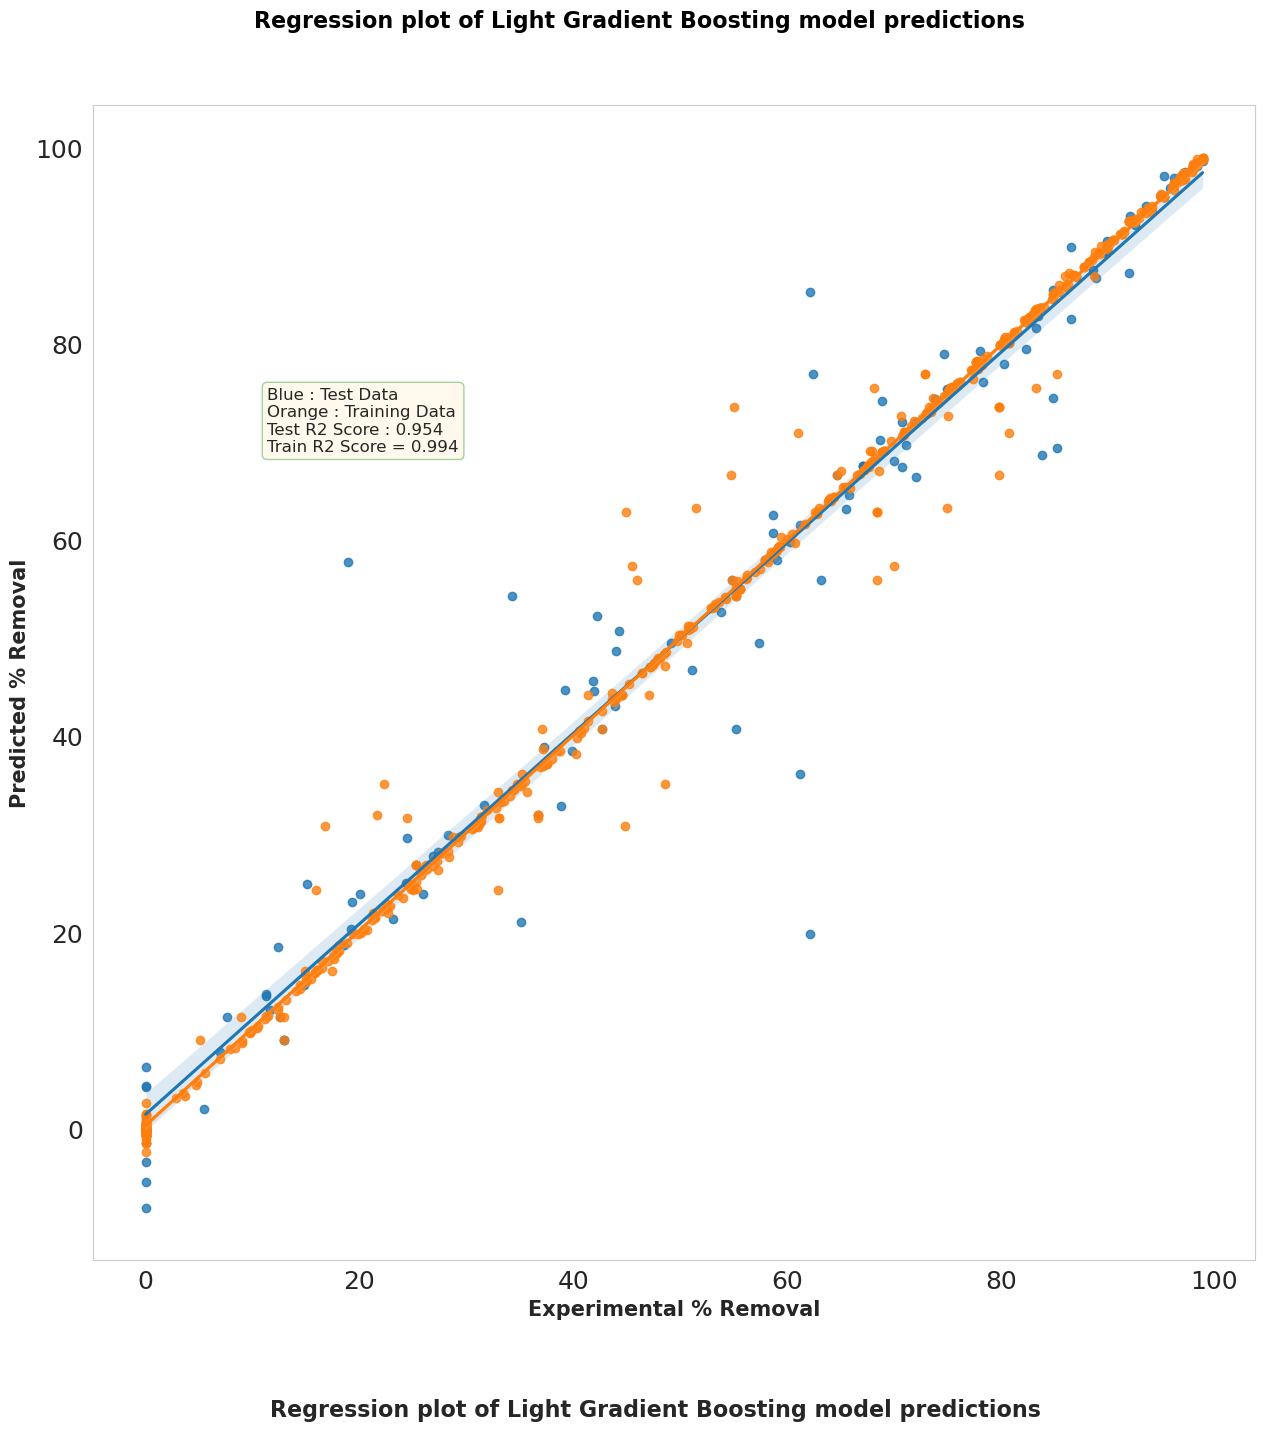

In [10]:
txt = 'Regression plot of Light Gradient Boosting model predictions'
# with open('op_Adaboost_R.pkl', 'rb') as file:
#     model = pickle.load(file)
fig = plt.figure(figsize=(15, 15))
sns.set_style('whitegrid')
plt.title(txt, y=1.06, x= .47, fontsize = 16, fontdict={'fontweight': 'bold', 'color': 'black'})
ax = sns.regplot(x=y_test, y=model.predict(X_test))
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
sns.regplot(x=y_train, y=model.predict(X_train))

stats = ('Blue : Test Data\n'
         'Orange : Training Data\n'
         f'Test R2 Score : {r2_score(y_test, model.predict(X_test)).round(3)}\n'
         f'Train R2 Score = {r2_score(y_train, model.predict(X_train)).round(3)}'
         )
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='green', alpha=0.35)
# ax.set(xlabel='Actual data', ylabel='Catboost model prediction')
ax.set_xlabel('Experimental % Removal', fontsize=15 ,fontdict={'fontweight': 'bold'})
ax.set_ylabel('Predicted % Removal', fontsize=15 ,fontdict={'fontweight': 'bold'})
ax.text(0.15, 0.7, stats, fontsize=12, bbox=bbox,
            transform=ax.transAxes, horizontalalignment='left')
fig.text(.5, .006, txt, ha='center', fontsize=16,fontdict={'weight': 'bold'})
plt.grid(None)
plt.savefig('images/Regression_plot_of_LGB_predictions.png', dpi=1900)
plt.show()

In [11]:
model1_predictions = np.array(df.iloc[:, :7])
np.expand_dims(model1_predictions, 0)
model1_predictions = model.predict(model1_predictions)
model1_predictions = np.around(model1_predictions, decimals=2)
model1_predictions = model1_predictions.tolist()
df['lgb'] = model1_predictions

In [12]:
# Step 1: Read the existing CSV file
existing_df = pd.read_csv('book1.csv')

# Assuming 'last_column' is the name of the last column in your DataFrame df
# Replace 'last_column' with the actual name of your last column
new_data = df['lgb']

# Step 2: Merge the DataFrames
merged_df = pd.concat([existing_df, new_data], axis=1)

# Step 3: Write the merged DataFrame to the CSV file
merged_df.to_csv('book1.csv', index=False)